## Setup
Import required libraries.

In [ ]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from napari_dinosim.dinoSim_pipeline import *
from napari_dinosim.utils import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

import h5py
from torch.nn import functional as F

In [ ]:
#@title Data and Processing Parameters

#@markdown ### Data Settings
dataset_path = '/home/tomwelch/Cambridge/Datasets/neurotransmitter_data' #@param {type:"string"}
dates = os.listdir(dataset_path)#@param {type:"string"}
neurotransmitters = os.listdir(os.path.join(dataset_path, dates[0])) #@param {type:"string"} 

#@markdown ### Post-processing Settings
upsample = "bilinear" #@param {type:"string", options:["bilinear", "Nearest Neighbor", "None"], value-map:{bilinear:"bilinear", "Nearest Neighbor": "nearest", None:None}}
crop_shape = (512,512,1) #@param {type:"raw"}

#@markdown ### Model Input Settings
#@markdown Should be multiple of model patch_size
resize_size = 518 #@param {type:"integer"}

## Load Data


In [ ]:
def load_image(path):
    with h5py.File(path) as f:
        pre, post = f['annotations/locations'][:]/8
        x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
        slice_volume = f['volumes/raw'][:][:,:,z]
        return slice_volume, x, y

In [ ]:
train_x_fnames = glob(os.path.join(dataset_path, dates[0], neurotransmitters[0], '*.hdf*'))
train_x_fnames.sort()

train_dataset = np.stack([load_image(p)[0] for p in train_x_fnames]).astype(np.uint8)
train_dataset = train_dataset[...,np.newaxis] # add channel dim

coordinates = np.stack([load_image(p)[1:] for p in train_x_fnames])

print(f'N files:  {len(train_dataset)} \t Shape: {train_dataset.shape[1:]}')

# Load Model

In [ ]:
# select model size
model_size = 'small' #@param {type:"string", options:["small", "base", "large", "giant"]}

model_dims = {'small': 384, 'base': 768, 'large': 1024, 'giant': 1536}
assert model_size in model_dims, f'Invalid model size: ({model_size})'
model = torch.hub.load('facebookresearch/dinov2', f'dinov2_vit{model_size[0]}14_reg')
model.to(device)
model.eval()

feat_dim = model_dims[model_size]

few_shot = DinoSim_pipeline(model, model.patch_size, device, get_img_processing_f(resize_size),
                             feat_dim, dino_image_size=resize_size )
print("Model loaded")

# Prompting

In [ ]:
# select reference points
x, y = coordinates[0]+[-5,0]
points = [(0, x, y),]
z, x, y = zip(*points)

plt.imshow(train_dataset[z[0]], 'gray')
plt.scatter(x, y, c='r', marker='x')
plt.show()

# DinoSim

In [ ]:
def gaussian_kernel(size=3, sigma=1):

    upper = size - 1
    lower = -int(size / 2)

    y, x = np.mgrid[lower:upper, lower:upper]

    kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(
        -(x**2 + y**2) / (2 * sigma**2)
    )
    kernel = kernel / kernel.sum()

    return kernel

In [ ]:
def torch_convolve(input, weights, mode="reflect", cval=0.0, origin=0):
    """
    Multidimensional convolution using PyTorch.

    Parameters
    ----------
    input : torch.Tensor
        The input tensor to be convolved.
    weights : torch.Tensor
        Convolution kernel, with the same number of dimensions as the input.
    mode : str, optional
        Padding mode. Options are 'reflect', 'constant', 'replicate', or 'circular'.
        Default is 'reflect'.
    cval : float, optional
        Value to fill past edges of input if `mode` is 'constant'. Default is 0.0.
    origin : int, optional
        Controls the origin of the input signal. Positive values shift the filter
        to the right, and negative values shift the filter to the left. Default is 0.

    Returns
    -------
    result : torch.Tensor
        The result of convolution of `input` with `weights`.
    """
    # Ensure input is 4D (batch, channels, height, width)
    if input.dim() == 2:  # Single channel 2D image
        input = input.unsqueeze(0).unsqueeze(0)
    elif input.dim() == 3:  # Add batch dimension if missing
        input = input.unsqueeze(0)

    # Add channel dimension for weights if necessary
    if weights.dim() == 2:
        weights = weights.unsqueeze(0).unsqueeze(0)

    # Apply padding based on mode
    padding = (
        weights.shape[-1] // 2 - origin
    )  # Adjust padding for origin shift
    input_padded = F.pad(
        input, (padding, padding, padding, padding), mode=mode, value=cval
    )

    # Perform convolution
    result = F.conv2d(input_padded, weights)

    return result.squeeze()  # Remove extra dimensions for output

In [ ]:
#Post-processing
kernel = gaussian_kernel(size=3, sigma=1)
kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
filter_f = lambda x: torch_convolve(x, kernel)

#few_shot.delete_precomputed_embeddings()
# few_shot.delete_references()
if not few_shot.emb_precomputed:
    few_shot.pre_compute_embeddings(train_dataset, overlap = (0,0), padding=(0,0), crop_shape=crop_shape, verbose=True, batch_size=5)
few_shot.set_reference_vector(list_coords=points)
distances = few_shot.get_ds_distances_sameRef(verbose=False)
predictions = few_shot.distance_post_processing(distances, filter_f, upsampling_mode=upsample)
print("Finished")

In [ ]:
predictions[6].shape

# Plot results

In [ ]:
# select threshold
threshold = 0.5

for i in range(1):
    input_img = train_dataset[i]
    plt.figure(figsize=(12,7))
    plt.subplot(131)
    if input_img.shape[-1] == 1:
        plt.imshow(input_img[...,0], 'gray')
    else:
        plt.imshow(input_img)
    plt.subplot(132)
    plt.imshow(1-predictions[i], 'magma')
    plt.subplot(133)
    plt.imshow(predictions[i] < threshold, 'gray')
    plt.show()

In [ ]:
def get_bbox(predictions, threshold):
    bbox_list = []
    failed = []
    try:
        for i in range(predictions.shape[0]):
            GT = (predictions[i] < threshold).astype(np.uint8)
            if np.sum(GT) == 0:
                failed.append(i)
                continue
            bbox_1x, bbox_1y = min(np.where(GT == 1)[1])-5, min(np.where(GT == 1)[0])-5
            bbox_2x, bbox_2y = max(np.where(GT == 1)[1])+5, max(np.where(GT == 1)[0])+5
            bbox_list.append(((bbox_1x, bbox_2x), (bbox_1y, bbox_2y)))
    except Exception as e:
        print(f"Error in bbox nb.{i}: {e}")
    
    print(f"{len(failed)/predictions.shape[0]*100}% of images did not pass the threshold")
    return bbox_list, len(failed)/predictions.shape[0]*100

In [ ]:
bboxes, _ = get_bbox(predictions, 0.35)

In [ ]:
def f(threshold):
    return get_bbox(predictions, threshold)[1]

plt.figure(figsize=(12,7), dpi=300)
thresholds = np.arange(0, 1.05, 0.05)
plt.plot(thresholds, [f(threshold)for threshold in thresholds])

# Setup

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from napari_dinosim.dinoSim_pipeline import *
from napari_dinosim.utils import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

import h5py
from torch.nn import functional as F
import torchvision.transforms.v2.functional as T
from torchvision import transforms
from tqdm import tqdm

Device: cpu


/home/tomwelch/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
list_neurotransmitters = {0:'acetylcholine',
                          1:'serotonin',
                          2:'gaba',
                          3:'glutamate',
                          4:'octopamine',
                          5:'dopamine'}

list_dates = {0: 'sylee_neurotrans_cubes_18Feb2025', 
              1:'sylee_neurotrans_cubes_24Mar2025'}

In [3]:
def get_img_processing_f(
    resize_size=224,
    interpolation=transforms.InterpolationMode.BICUBIC,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
):
    # input  tensor: [(b),h,w,c]
    # output tensor: [(b),c,h,w]
    def _img_processing_f(x):
        if len(x.shape) == 4:
            if x.shape[-1] == 1:
                x = x.repeat(1, 1, 1, 3)
            x = x.permute(0, 3, 1, 2)
        else:
            if x.shape[-1] == 1:
                x = x.repeat(1, 1, 3)
            x = x.permute(2, 0, 1)
        x = T.resize(
            x, resize_size, interpolation=interpolation, antialias=True
        )
        x = T.normalize(x, mean=mean, std=std)
        return x

    return _img_processing_f


In [4]:
def load_image(path):
    with h5py.File(path) as f:
        pre, post = f['annotations/locations'][:]/8
        x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
        slice_volume = f['volumes/raw'][:][:,:,z]
        return slice_volume, x, y

In [5]:
def gaussian_kernel(size=3, sigma=1):

    upper = size - 1
    lower = -int(size / 2)

    y, x = np.mgrid[lower:upper, lower:upper]

    kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(
        -(x**2 + y**2) / (2 * sigma**2)
    )
    kernel = kernel / kernel.sum()

    return kernel

In [6]:
def torch_convolve(input, weights, mode="reflect", cval=0.0, origin=0):
    if input.dim() == 2:
        input = input.unsqueeze(0).unsqueeze(0)
    elif input.dim() == 3: 
        input = input.unsqueeze(0)

    if weights.dim() == 2:
        weights = weights.unsqueeze(0).unsqueeze(0)

    padding = (
        weights.shape[-1] // 2 - origin
    ) 
    input_padded = F.pad(
        input, (padding, padding, padding, padding), mode=mode, value=cval
    )
    result = F.conv2d(input_padded, weights)

    return result.squeeze()

In [7]:
def get_bbox(predictions, threshold):
    bbox_list = []
    failed = []
    try:
        for i in range(predictions.shape[0]):
            GT = (predictions[i] < threshold).astype(np.uint8)
            if np.sum(GT) == 0:
                failed.append(i)
                continue
            bbox_1x, bbox_1y = min(np.where(GT == 1)[1])-5, min(np.where(GT == 1)[0])-5
            bbox_2x, bbox_2y = max(np.where(GT == 1)[1])+5, max(np.where(GT == 1)[0])+5
            bbox_list.append(((bbox_1x, bbox_2x), (bbox_1y, bbox_2y)))
    except Exception as e:
        print(f"Error in bbox nb.{i}: {e}")
    
    #print(f"{len(failed)/predictions.shape[0]*100}% of images did not pass the threshold")
    return bbox_list, len(failed)/predictions.shape[0]*100

In [17]:
def f(predictions, threshold):
    return get_bbox(predictions, threshold)[1]

In [9]:
#@title Data and Processing Parameters

#@markdown ### Data Settings
dataset_path = '/home/tomwelch/Cambridge/Datasets/neurotransmitter_data' #@param {type:"string"}
dates = os.listdir(dataset_path)#@param {type:"string"}
neurotransmitters = os.listdir(os.path.join(dataset_path, dates[0])) #@param {type:"string"} 

#@markdown ### Post-processing Settings
upsample = "bilinear" #@param {type:"string", options:["bilinear", "Nearest Neighbor", "None"], value-map:{bilinear:"bilinear", "Nearest Neighbor": "nearest", None:None}}
crop_shape = (512,512,1) #@param {type:"raw"}

#@markdown ### Model Input Settings
#@markdown Should be multiple of model patch_size
resize_size = 518 #@param {type:"integer"}

In [10]:
# select model size
model_size = 'small' #@param {type:"string", options:["small", "base", "large", "giant"]}

model_dims = {'small': 384, 'base': 768, 'large': 1024, 'giant': 1536}
assert model_size in model_dims, f'Invalid model size: ({model_size})'
model = torch.hub.load('facebookresearch/dinov2', f'dinov2_vit{model_size[0]}14_reg')
model.to(device)
model.eval()

feat_dim = model_dims[model_size]

few_shot = DinoSim_pipeline(model, model.patch_size, device, get_img_processing_f(resize_size),
                             feat_dim, dino_image_size=resize_size )
print("Model loaded")

Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [29]:
def DINOSim():
    '''
    Runs few-shot DINO-based detection over all dates and 6 neurotransmitters,
    and plots success rate over thresholds in a 2x3 subplot grid.
    '''
    thresholds = np.arange(0, 1.05, 0.05)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    for i, neuro in enumerate(neurotransmitters):
        all_success_rates = []

        for date in dates:
            # Load files
            train_x_fnames = glob(os.path.join(dataset_path, date, neuro, '*.hdf*'))
            train_x_fnames.sort()

            # Skip if no data
            if len(train_x_fnames) == 0:
                print(f"Skipping {neuro} on {dates[date]} (no data)")
                continue

            train_dataset = np.stack([load_image(p)[0] for p in train_x_fnames])
            train_dataset = train_dataset[..., np.newaxis]
            coordinates = np.stack([load_image(p)[1:] for p in train_x_fnames])
            points = [(0, coord[0], coord[1]) for coord in coordinates]

            # Convolution kernel
            kernel = gaussian_kernel(size=3, sigma=1)
            kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
            filter_f = lambda x: torch_convolve(x, kernel)

            # Few-shot setup
            few_shot.delete_precomputed_embeddings()
            few_shot.delete_references()
            if not few_shot.emb_precomputed:
                few_shot.pre_compute_embeddings(train_dataset[:50], 
                                                overlap=(0, 0),
                                                padding=(0, 0),
                                                crop_shape=crop_shape, 
                                                verbose=False,
                                                batch_size=5)
            print('Done')
            predictions = []

            for point in tqdm(points, desc=f'{neuro} on {date}'):
                few_shot.set_reference_vector(list_coords=[(0, point[0], point[1])])
                distances = few_shot.get_ds_distances_sameRef(verbose=False)
                pred = few_shot.distance_post_processing(distances, filter_f, upsampling_mode=upsample)
                predictions.append(pred)

            predictions = np.array(predictions)
            failure_rate = [f(predictions, t) for t in thresholds]
            all_failure_rates.append(failure_rate)

        # Average across dates
        if all_success_rates:
            mean_rates = np.mean(all_success_rates, axis=0)
            axs[i].plot(thresholds, mean_rates, label=neuro)
            axs[i].set_title(f'{neuro}')
            axs[i].set_xlabel('Threshold')
            axs[i].set_ylabel('Success Rate')
            axs[i].grid(True)
            axs[i].legend()

    plt.suptitle('Success Rate vs Threshold for Neurotransmitters', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Precomputing embeddings


acetylcholine on sylee_neurotrans_cubes_18Feb2025: 100%|██████████| 300/300 [00:54<00:00,  5.49it/s]


Precomputing embeddings


acetylcholine on sylee_neurotrans_cubes_24Mar2025: 100%|██████████| 300/300 [00:52<00:00,  5.76it/s]


KeyboardInterrupt: 

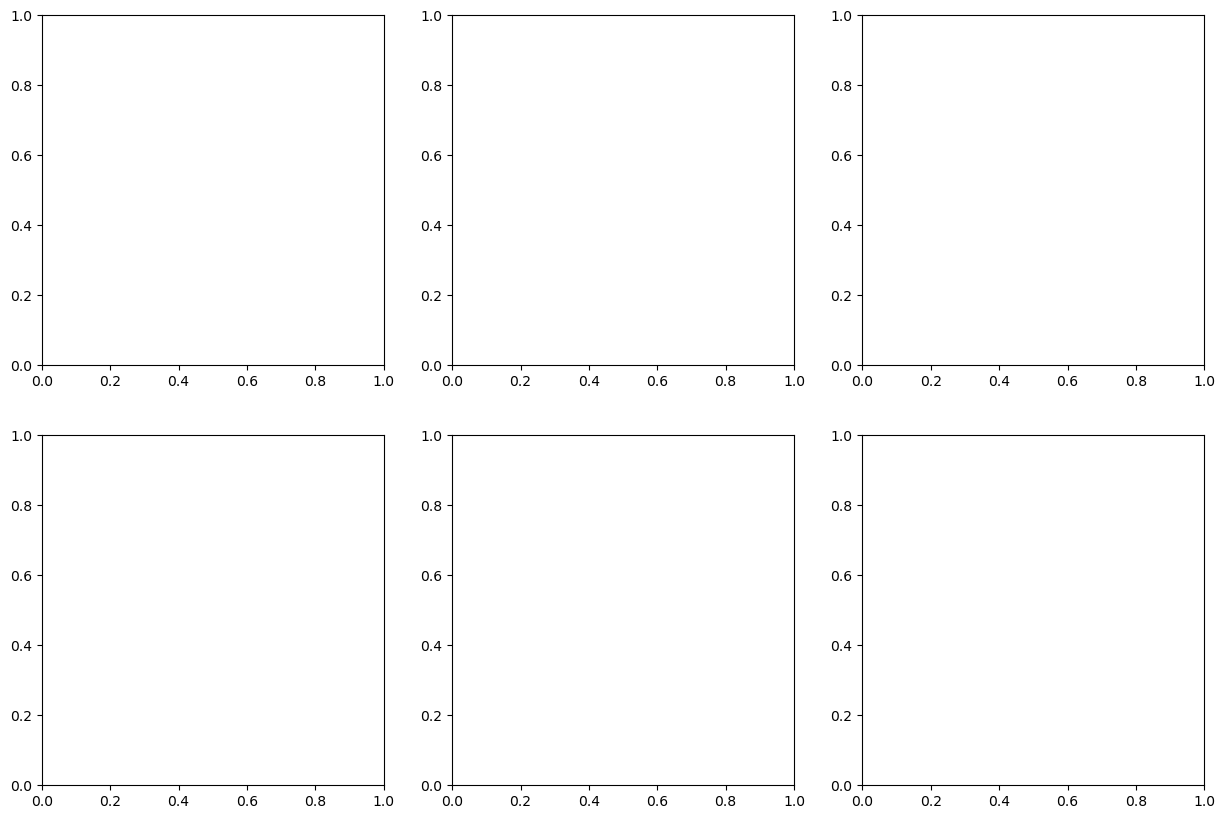

In [28]:
DINOSim()